In [1]:
# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm

# pandas options
pd.set_option('mode.copy_on_write', True)  # pandas 2.0
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7  # max number of rows to display

# NumPy options
np.set_printoptions(precision = 2, suppress=True)  # suppress scientific notation

# For high resolution display
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [6]:
# Build a rangeplot!
def rangeplot(df, x, y, color=None):
    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dots(pointsize=8, marker="<"), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )

def boxplot(df, x, y, color=None, alpha=0.1):
    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Dots(alpha=alpha, color=".6"), so.Jitter(), so.Dodge())
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dots(pointsize=8, marker="<"), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )

In [4]:
bikeshare_daily = pd.read_csv("day.csv")


def clean_data(df):
    df.rename({"dteday": "date", "cnt": "count"}, axis=1, inplace=True)

    df = df.assign(
        date=lambda x: pd.to_datetime(x["date"]),  # datetime type으로 변환
        year=lambda x: x["date"].dt.year.astype(str),  # year 추출
        day=lambda x: x["date"].dt.day_of_year,  # day of the year 추출
        month=lambda x: x["date"].dt.month_name().str[:3],  # month 추출
        wday=lambda x: x["date"].dt.day_name().str[:3],  # 요일 추출
    )

    df["season"] = (
        df["season"]
        .map({1: "winter", 2: "spring", 3: "summer", 4: "fall"})  # season을 문자열로 변환
        .astype("category")  # category type으로 변환
        .cat.set_categories(
            ["winter", "spring", "summer", "fall"], ordered=True
        )  # 순서를 지정
    )
    return df

bikes_daily = clean_data(bikeshare_daily)

# 1년에 걸친 트렌드 확인
## 1년에 걸친 트렌드: casual + registered = count인데, casual은 등록 안 하고 바로 타는 것, registered 등록하고 타는 것.
## 실제 보면 casual, registered 두 그룹이 많이 다르다. 또한 2011, 2012년도 서로 많이 다르다. 다른 이유는 상식적으로 기온이 다를 수도 있고, 온도가 자전거 타러 나오는 중요한 요소니까. 연도가 바뀌면서 바이크 렌탈의 정책이 바뀔 수가 있다. 연도가 2개밖에 없으니까 1년에 걸친 패턴을 찾는다는 게 무리다. 따로 보는 것도 괜찮은 방법이지만….

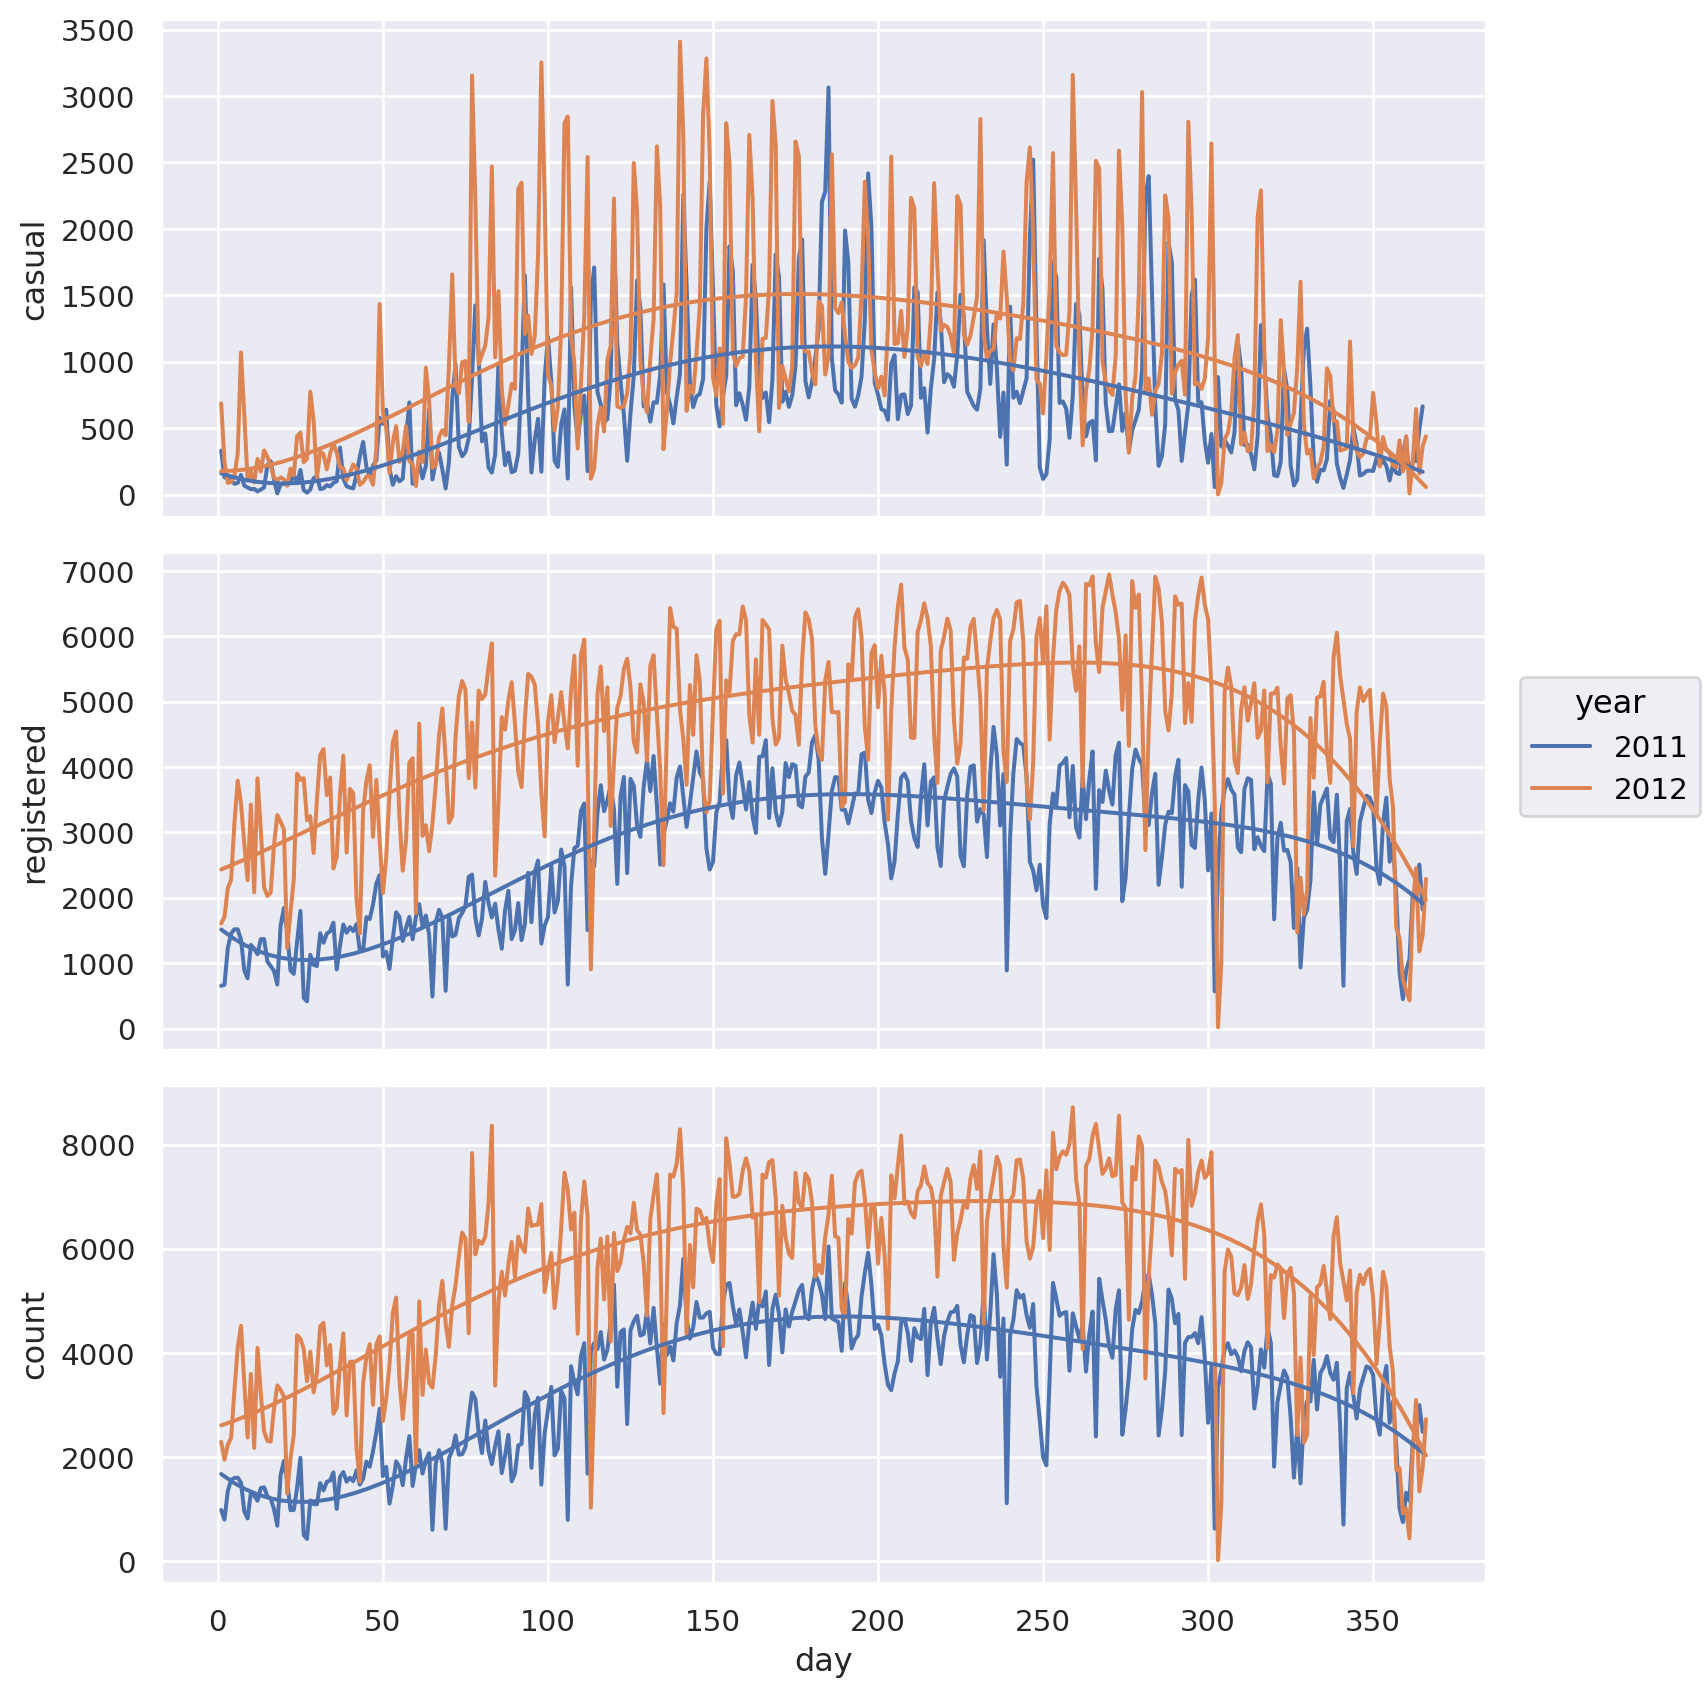

In [5]:
(
    so.Plot(bikes_daily, x='day', color="year")
    .pair(y=['casual', 'registered', 'count'])
    .add(so.Line())
    .add(so.Line(), so.PolyFit(5))
    .layout(size=(8, 9))
)

## 2011년에 상당히 추웠고, 온도 때문에 생긴 차이지, 연도 차이는 아닐 수도 있다.

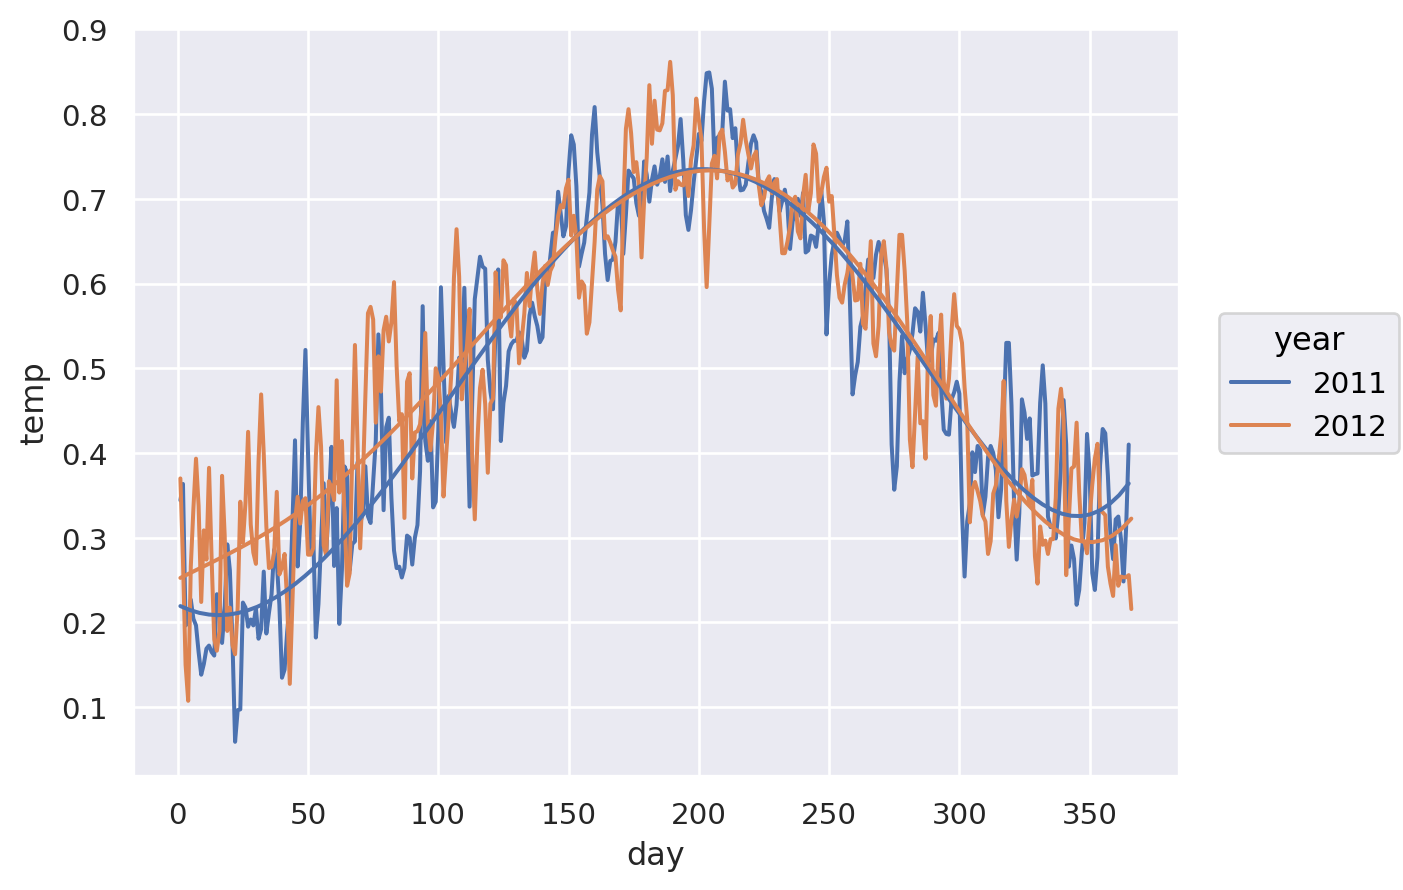

In [7]:
(
    so.Plot(bikes_daily, x='day', y='temp', color="year")
    .add(so.Line())
    .add(so.Line(), so.PolyFit(5))
)

## casual은 주말에 많이 타러 나온다.

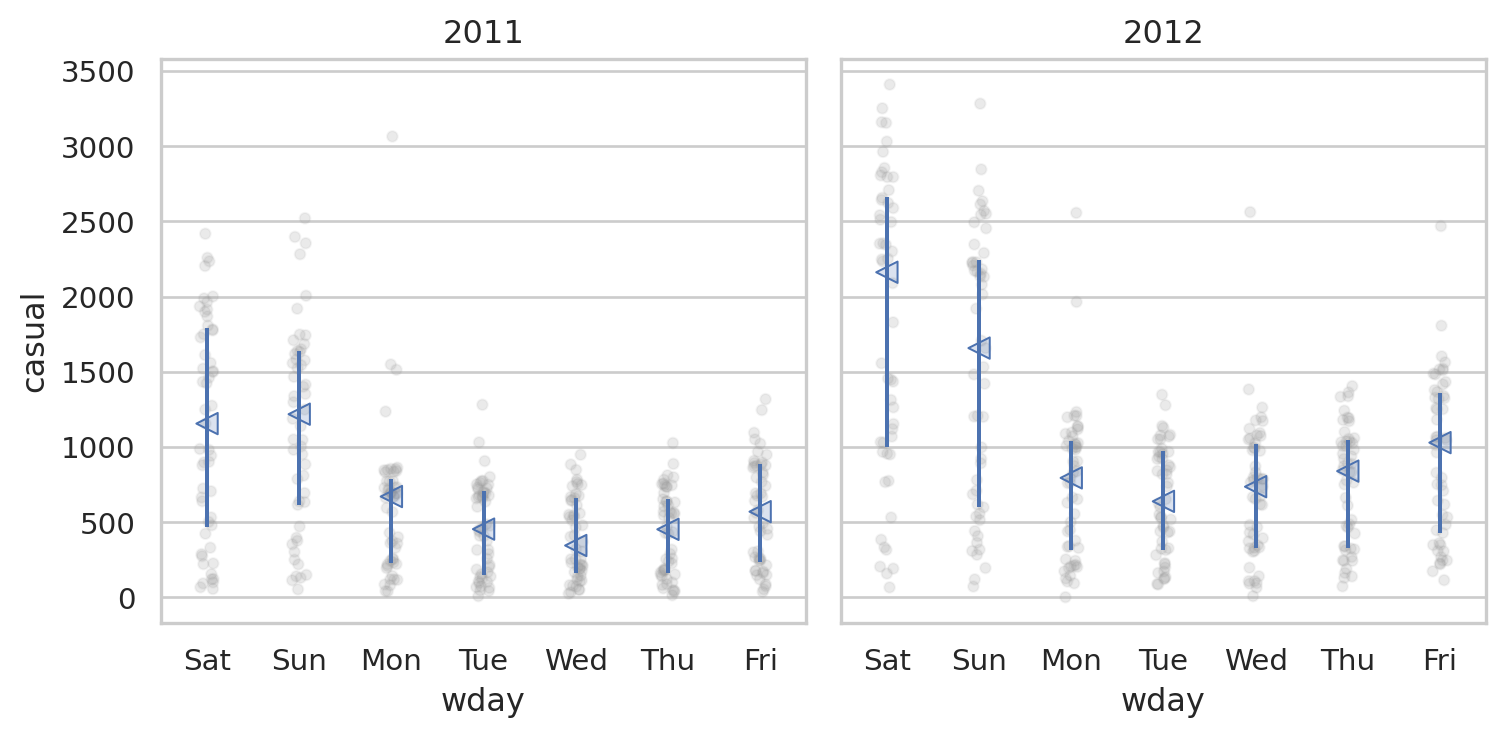

In [8]:
# 요일에 따라 차이가 있는가?

(
    boxplot(bikes_daily, x="wday", y="casual")
    .facet("year")
    .layout(size=(8, 4))
)

## registered는 패턴이 casual과 반대다.

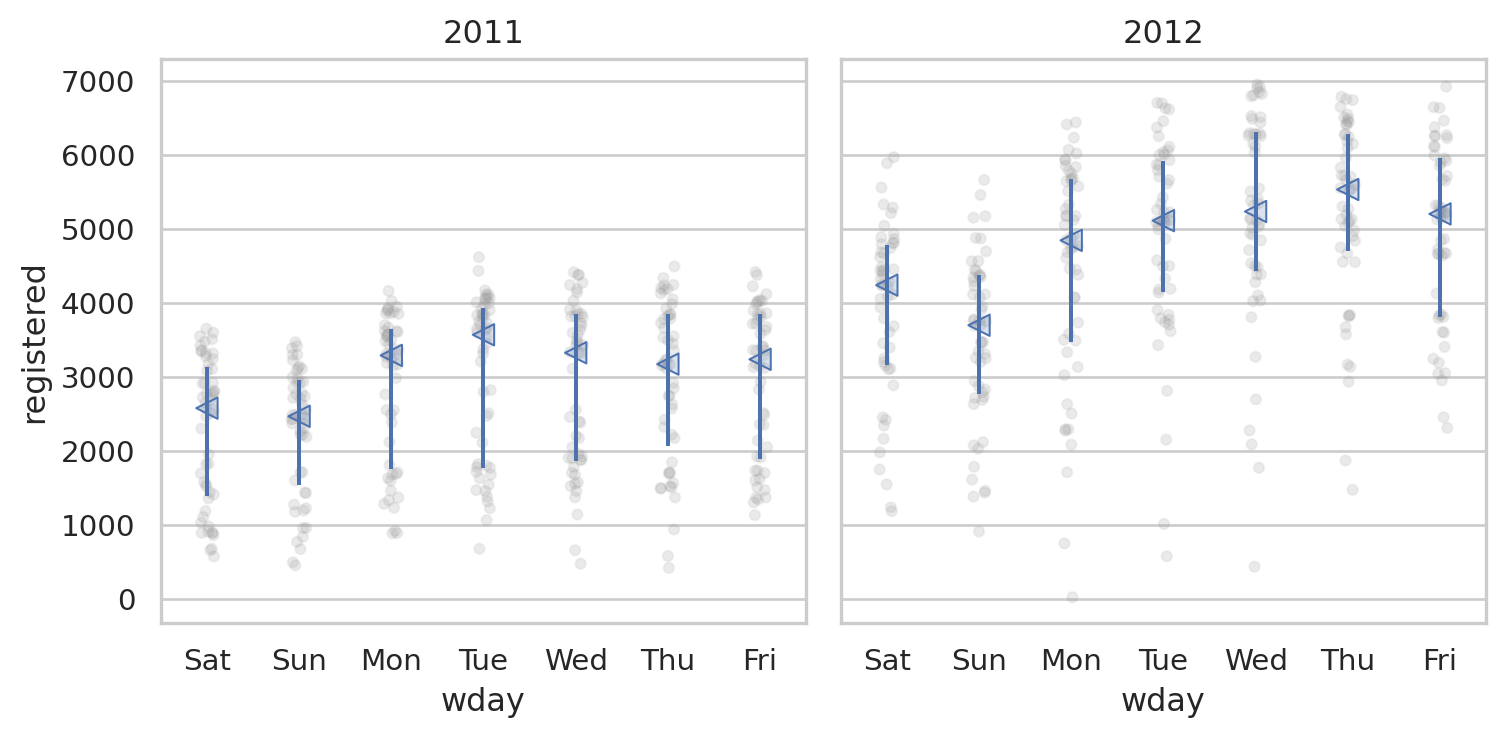

In [9]:
(
    boxplot(bikes_daily, x="wday", y="registered")
    .facet("year")
    .layout(size=(8, 4))
)

## month 플롯을 봐도 날씨 때문에 1년, 달에 관련된 패턴이 나온다고 볼 수 있다. 단, casual은 온도랑 너무 nice하게 같이 가고, registered는 그정돈 아니다.

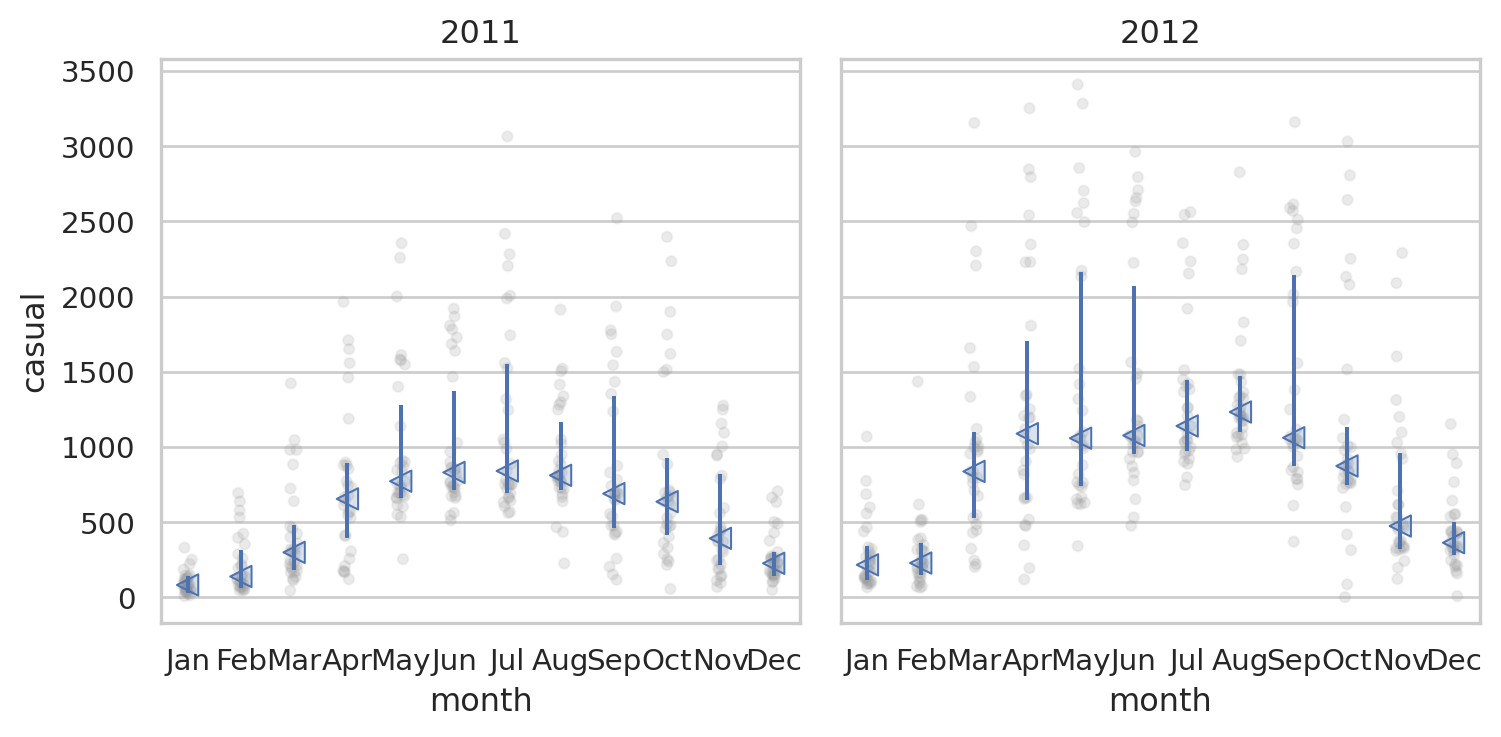

In [10]:
# 달에 따라 차이가 있는가?
(
    boxplot(bikes_daily, x="month", y="casual")
    .facet("year")
    .layout(size=(8, 4))
)

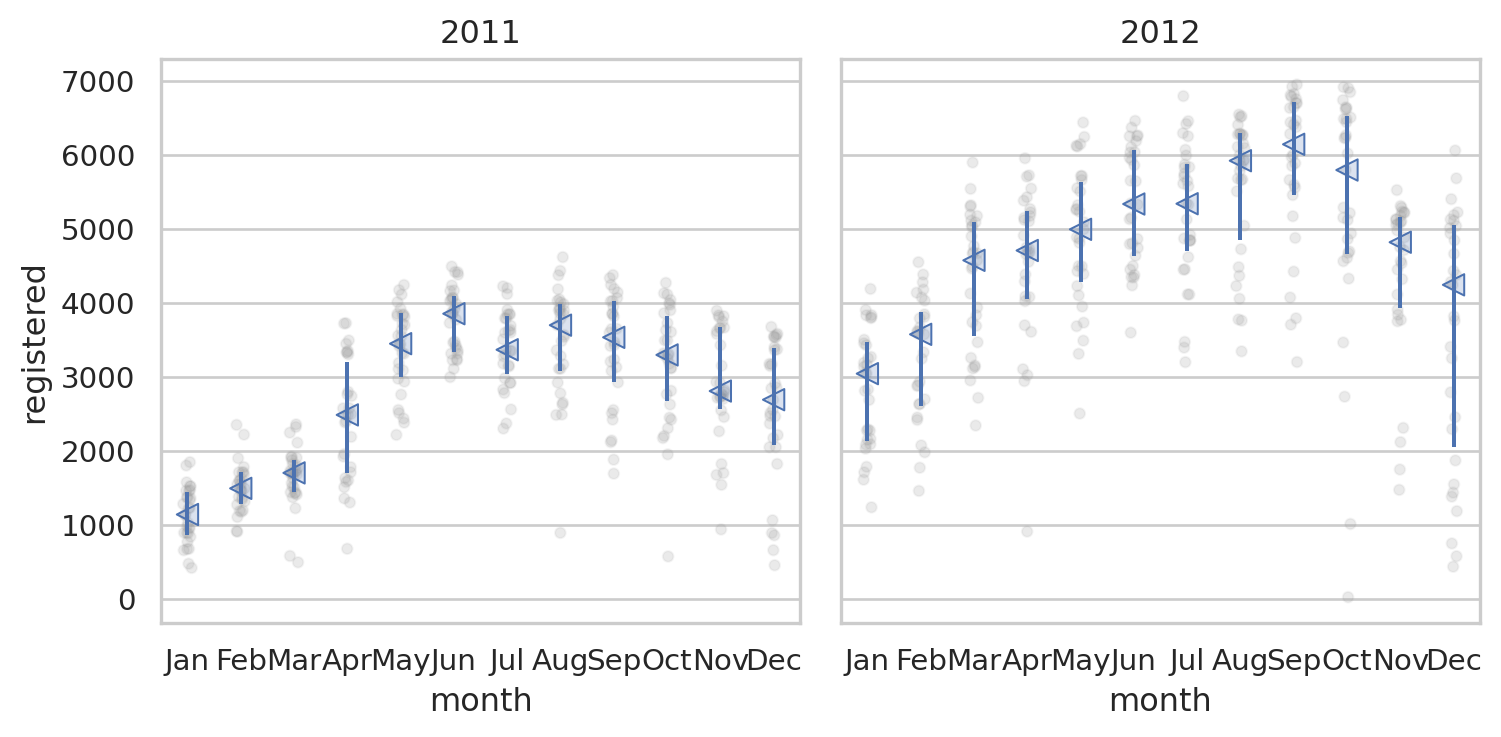

In [11]:
(
    boxplot(bikes_daily, x="month", y="registered")
    .facet("year")
    .layout(size=(8, 4))
)

## 너무 더워지면 못 타니까 커지면 당연히 떨어진다. casual, registered를 보면 casual은 위에 붕 떠 있고(퍼지고), registered는 붕 떠 있지 않다. 저 붕 떠지는 현상을 잘 감안해야 한다. 우리가 좋아하는 건 registered처럼 붕 떠 있지 않은 것.

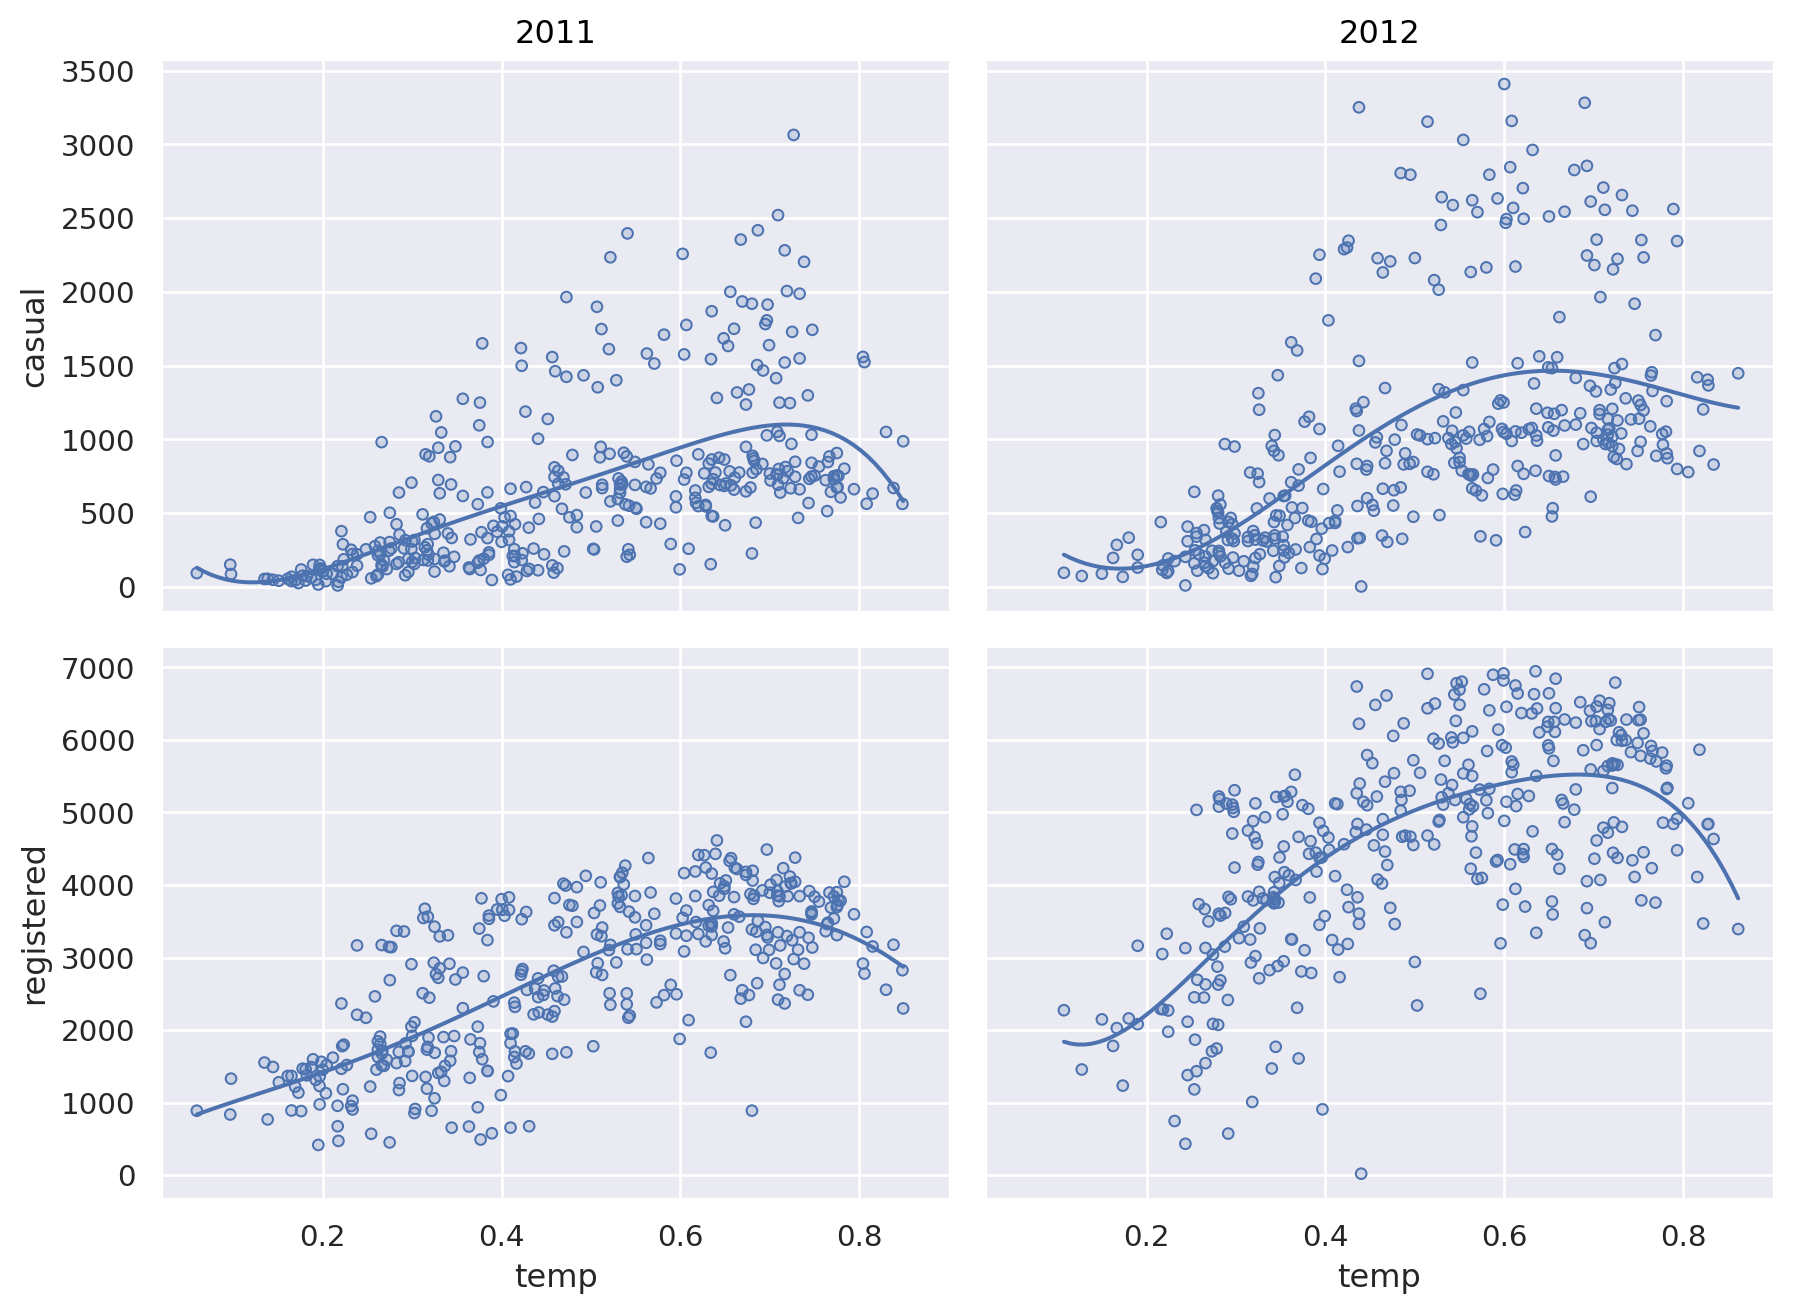

In [12]:
# 기온에 따라 차이가 있는가?
(
    so.Plot(bikes_daily, x='temp')
    .pair(y=['casual', 'registered'])
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(5))
    .facet("year")
    .layout(size=(9.5, 7))
)

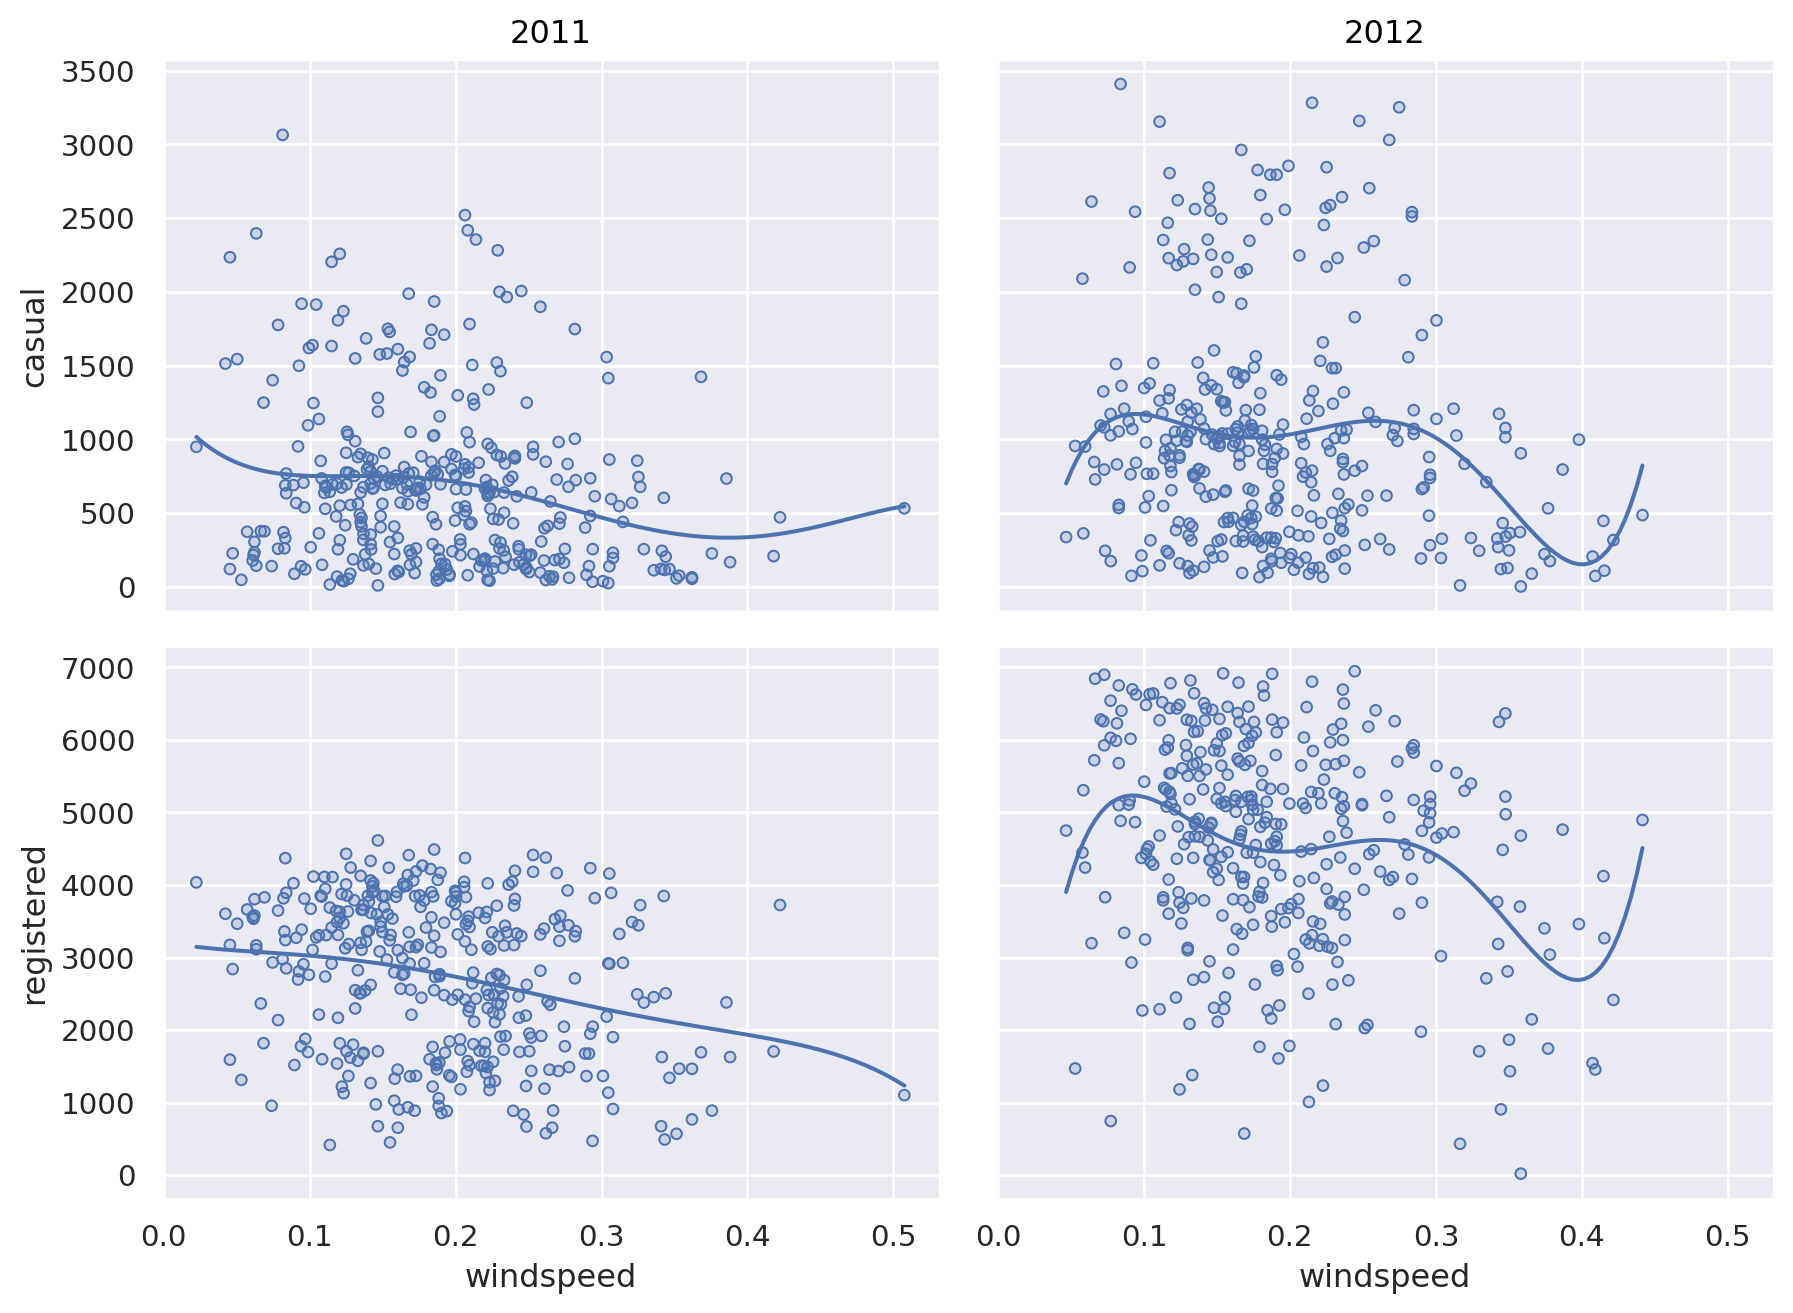

In [13]:
# 바람의 세기에 따라 차이가 있는가?
(
    so.Plot(bikes_daily, x='windspeed')
    .pair(y=['casual', 'registered'])
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(5))
    .facet("year")
    .layout(size=(9.5, 7))
)

## 온도에 파란색이 5차 함수 트렌드 라인, 빨간색은 2차 함수, 검정색은 2011, 2012년 안 나눴을 때 트렌드 라인. —> 이걸 보니까 2차 함수 fit하면 마지막에 떨어지는 게 살아나지 않으니까 2차 함수로는 충분하지 않지만, 2차 함수로 fit해보자?

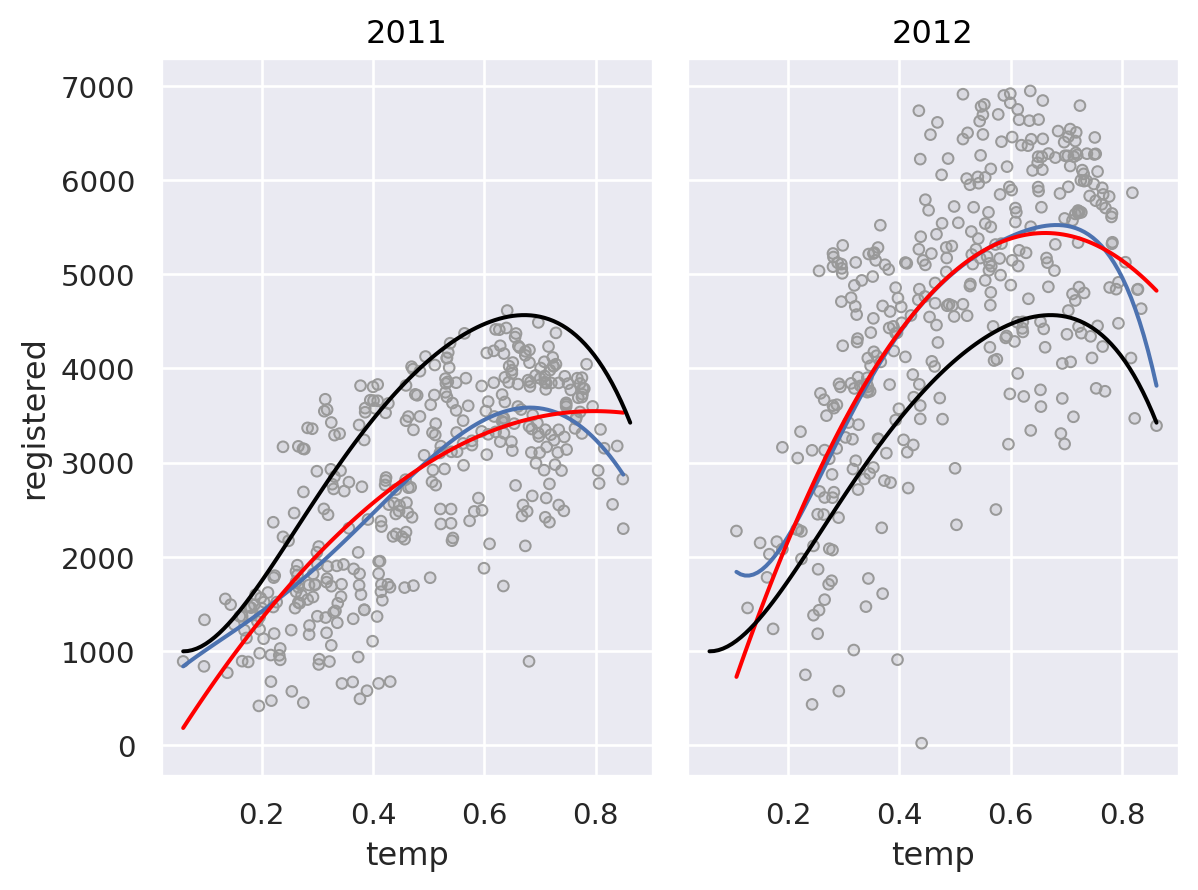

In [14]:
(
    so.Plot(bikes_daily, x='temp', y='registered')
    .add(so.Dots(color=".6"))
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color="red"), so.PolyFit(2))
    .add(so.Line(color="black"), so.PolyFit(5), col=None)
    .facet("year")
)

# 모델 구현
## formula에서 I 안에 있는 건 실제 산술적 의미를 가진다. +, * 보통 SYMBOL인데, I 안에 있는 건 실제 계산이 된다는 의미.
## mod_r1 = smf.ols("registered ~ temp + I(temp**2) + year", data=bikes_daily).fit()연도에 따라서 온도의 패턴이 다르지 않다는 의미
## mod_r2 = smf.ols("registered ~ (temp + I(temp**2)) * year", data=bikes_daily).fit() 연도에 따라서 온도의 패턴이 다를 것이라고 가정한다는 의미

In [15]:
import statsmodels.formula.api as smf
mod_r1 = smf.ols("registered ~ temp + I(temp**2) + year", data=bikes_daily).fit()
mod_r2 = smf.ols("registered ~ (temp + I(temp**2)) * year", data=bikes_daily).fit()

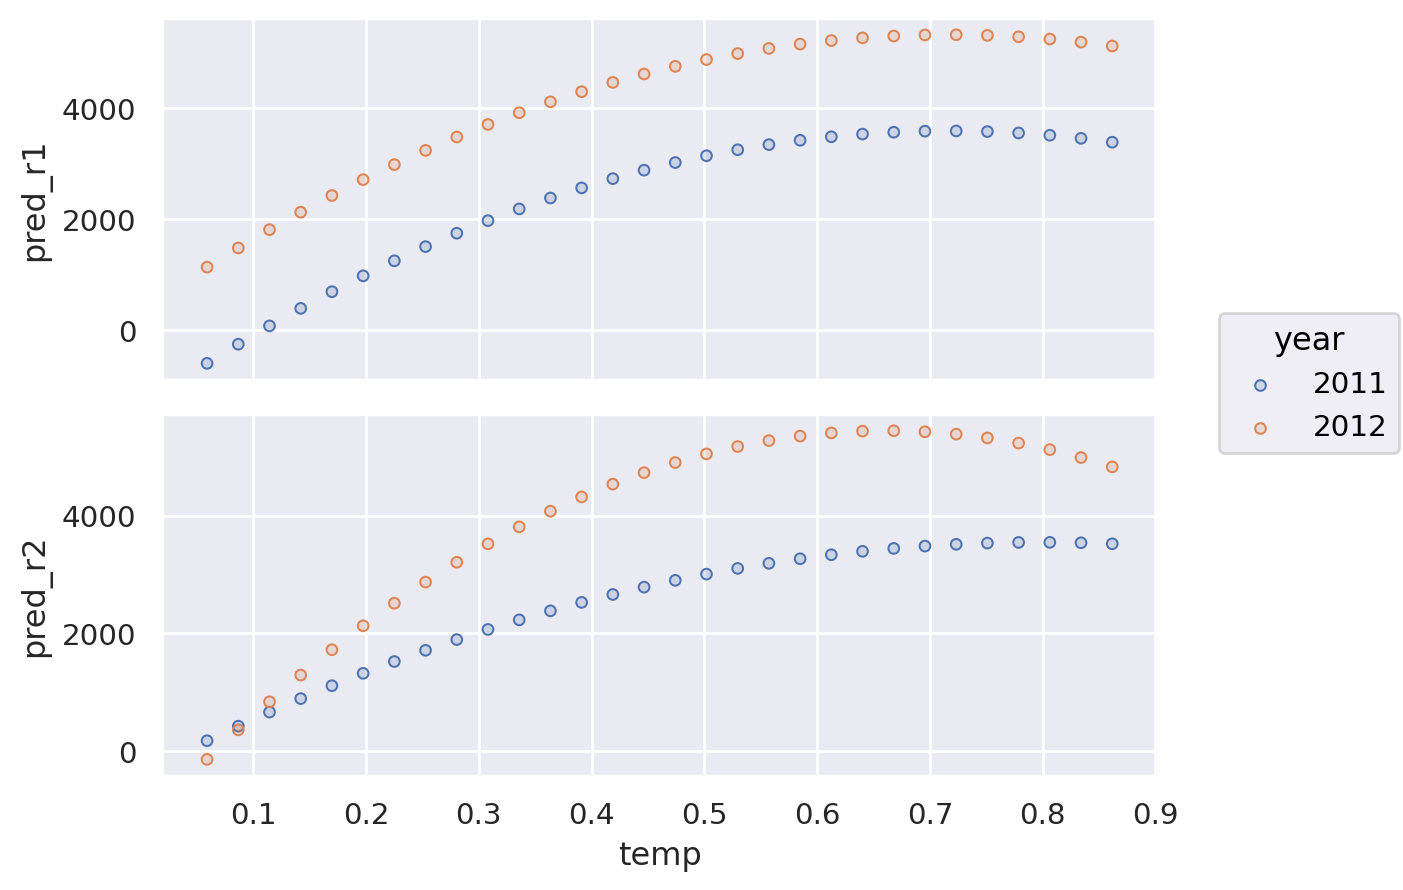

In [16]:
temp = np.linspace(bikes_daily["temp"].min(), bikes_daily["temp"].max(), 30)
year = np.array(["2011", "2012"])

from itertools import product
grid = pd.DataFrame(
    list(product(temp, year)),
    columns=["temp", "year"],
)
grid["pred_r1"] = mod_r1.predict(grid)
grid["pred_r2"] = mod_r2.predict(grid)

(
    so.Plot(grid, x='temp', color="year")
    .pair(y=['pred_r1', 'pred_r2'])
    .add(so.Dots())
)

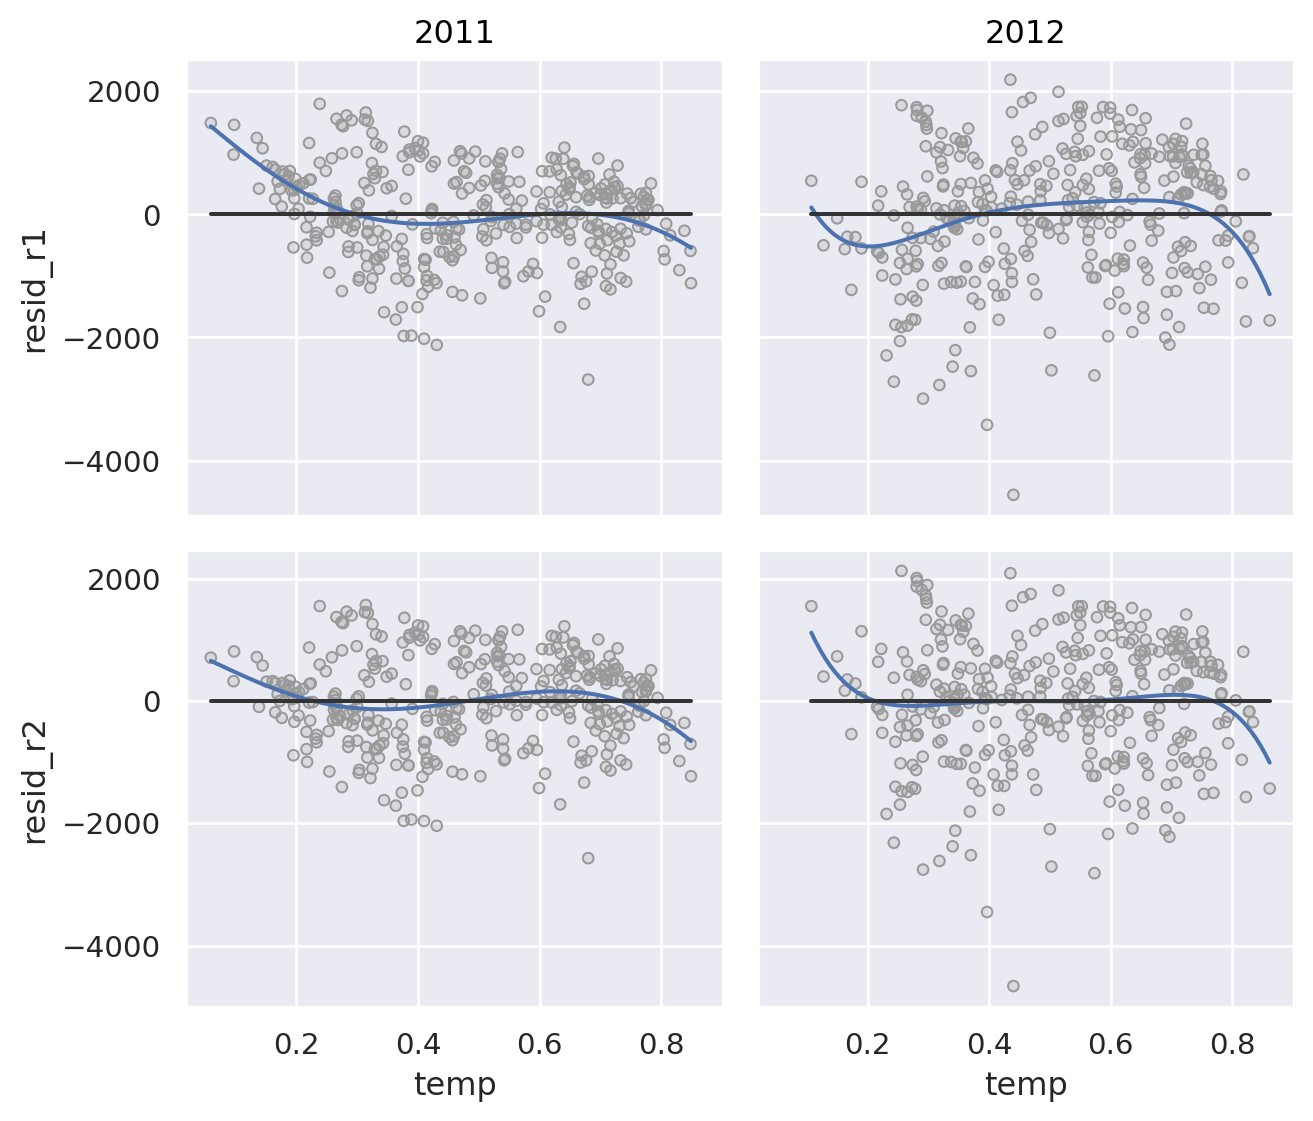

In [17]:
bikes_daily_resid = bikes_daily.assign(
    resid_r1 = mod_r1.resid,
    resid_r2 = mod_r2.resid
)

(
    so.Plot(bikes_daily_resid, x='temp')
    .pair(y=['resid_r1', 'resid_r2'])
    .add(so.Dots(color='.6'))
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color=".2"), so.Agg(lambda x: 0))
    .facet("year")
    .layout(size=(7, 6))
)

## 온도와 달이 비슷한 정보를 가지고 있으니까 온도랑 달을 동시에 사용할 이유가 있겠느냐??? 9~11월에는 온도로는 예측되지 않는, 즉 같은 온도라고 해도 자전거를 특별히 더 대여하게 되는 특성이 있을 수 있음. 반대로, 2월에서 4월에는 온도로는 예측되지 않는 자건거를 특별히 더 적게 대여하게 되는 특성이 있을 수 있음. 온도가 설명해주지 못한 것으로 달이 설명해주는 게 있다고 해석할 수도 있음.

In [18]:
mod = smf.ols('temp ~ month', data=bikes_daily).fit()
mod.rsquared

0.8378460473171662

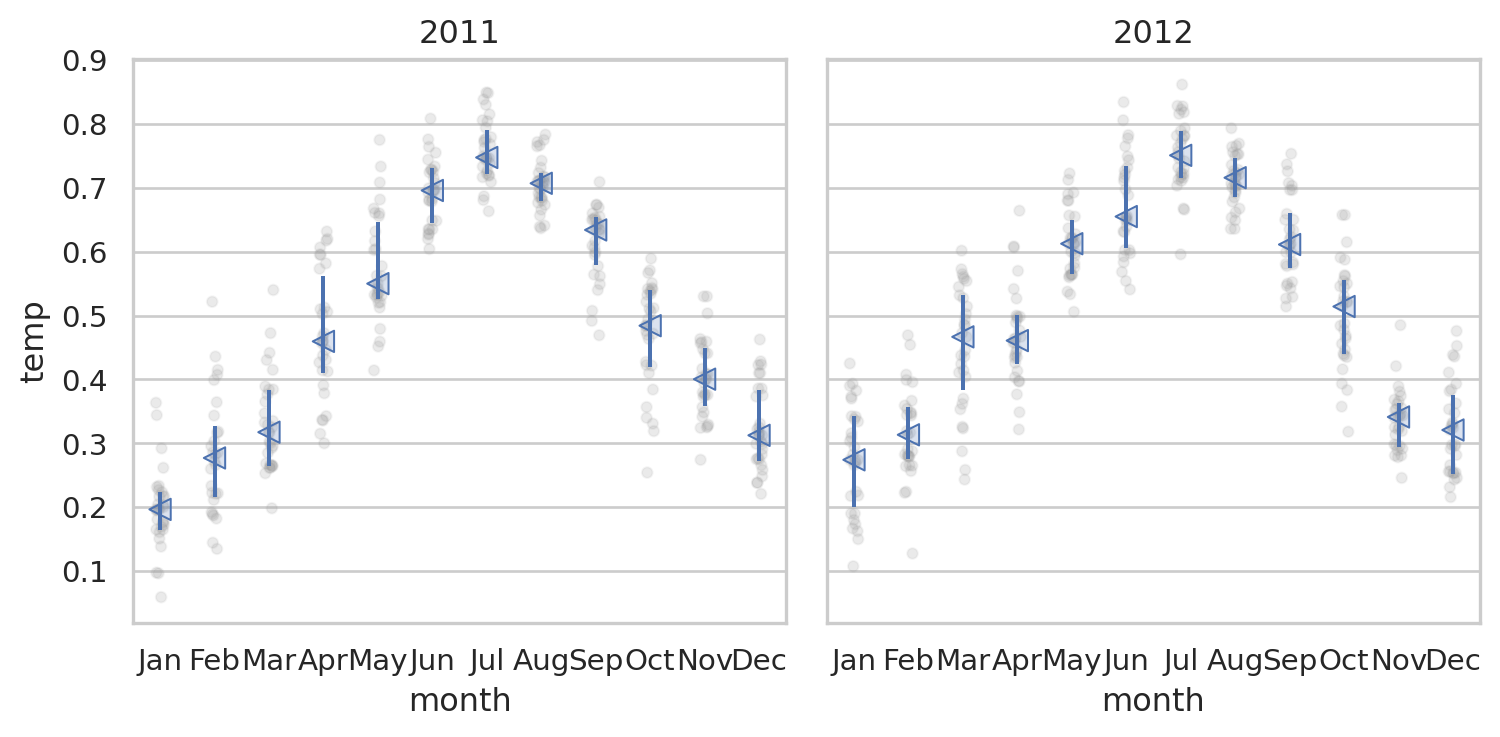

In [19]:
(
    boxplot(bikes_daily, x='month', y='temp')
    .facet("year")
    .layout(size=(8, 4))
)

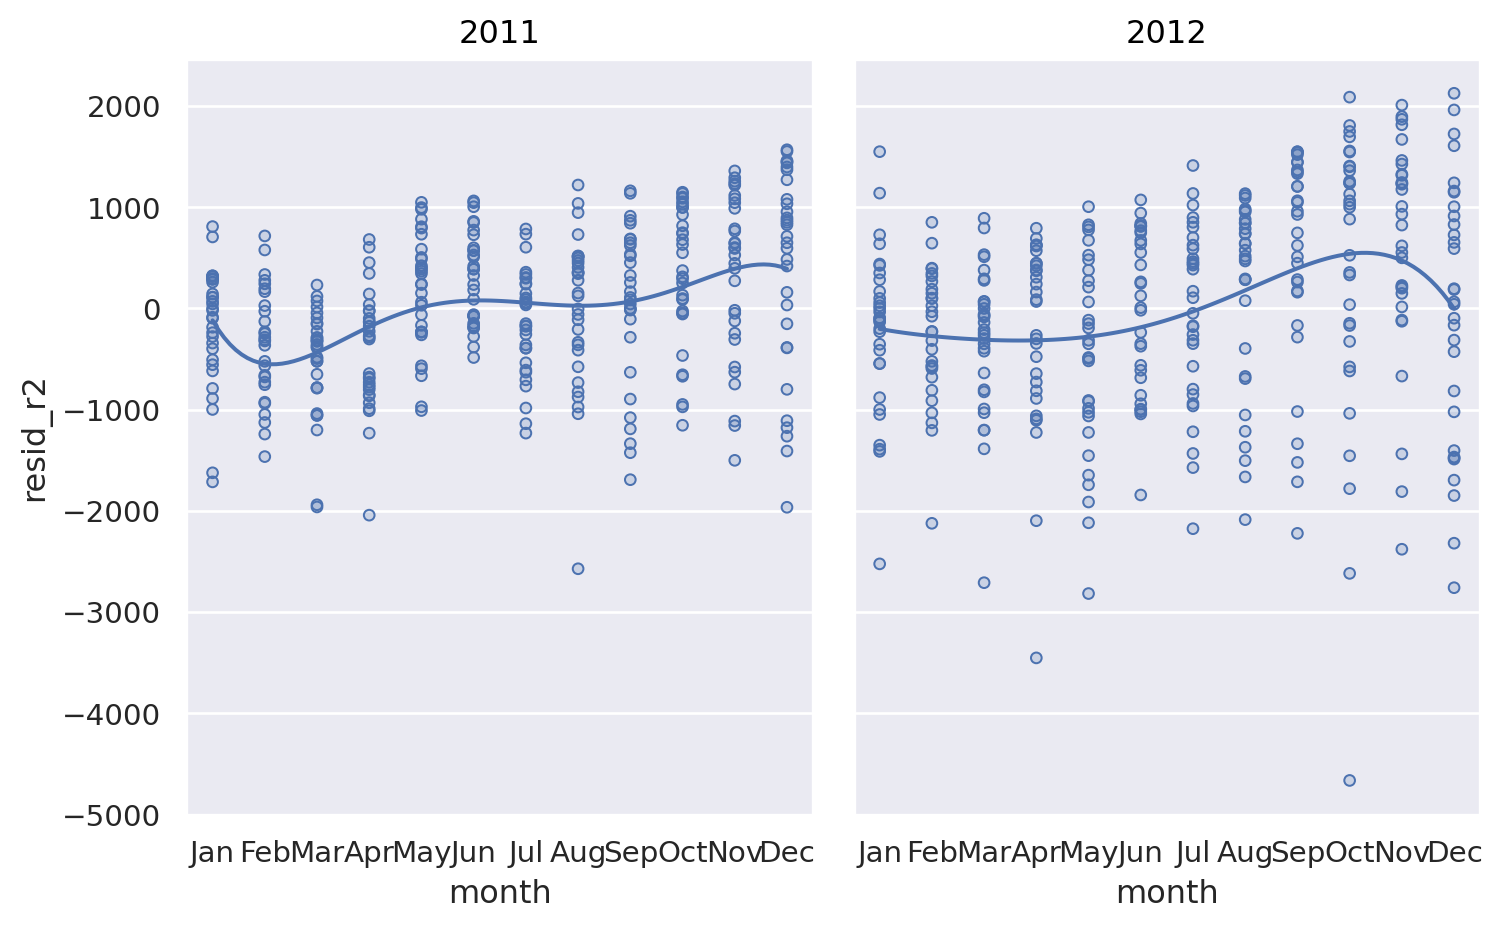

In [20]:
(
    so.Plot(bikes_daily_resid, x='month', y='resid_r2')
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(5))
    .facet("year")
    .layout(size=(8, 5))
)

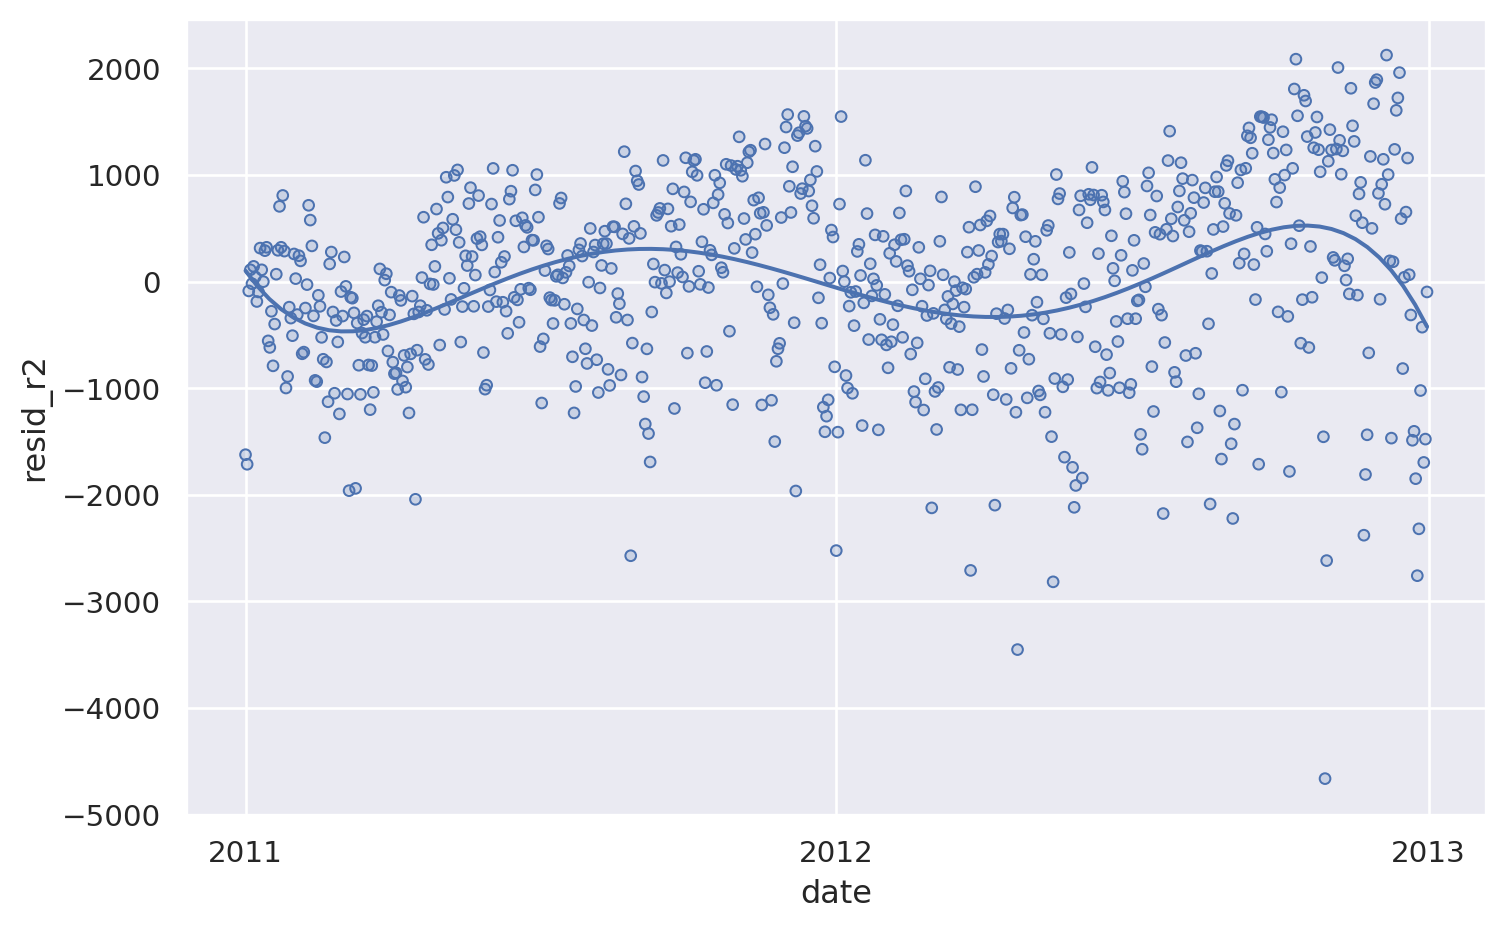

In [21]:
(
    so.Plot(bikes_daily_resid, x='date', y='resid_r2')
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(5)) # grouping by year
    .layout(size=(8, 5))
)

In [22]:
bikes_daily["month"] = bikes_daily["month"].astype("category")
bikes_daily["month"] = bikes_daily["month"].cat.set_categories(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)

In [23]:
mod_r3 = smf.ols("registered ~ (temp + I(temp**2)) * year + month", data=bikes_daily).fit()

In [24]:
display(mod_r3.rsquared, mod_r2.rsquared)  # month 추가로 인한 R2가 증가분

0.7053133858977505

0.6681657121983411

In [25]:
print(mod_r3.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:             registered   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.699
No. Observations:                 731   F-statistic:                     106.8
Covariance Type:            nonrobust   Prob (F-statistic):          5.06e-177
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   180.4223    321.376      0.561      0.575    -450.533     811.377
year[T.2012]              -1303.6849    477.877     -2.728      0.007   -2241.898    -365.472
month[T.Feb]                 16.8031    163.242      0.103      0.918    -303.688     337.295
month[T.Mar]                 70.8817    178.488      0.397      0.691    -279.542     421.306
month[T.Apr]                291.0581    1

In [26]:
bikes_daily_resid["resid_r3"] = mod_r3.resid

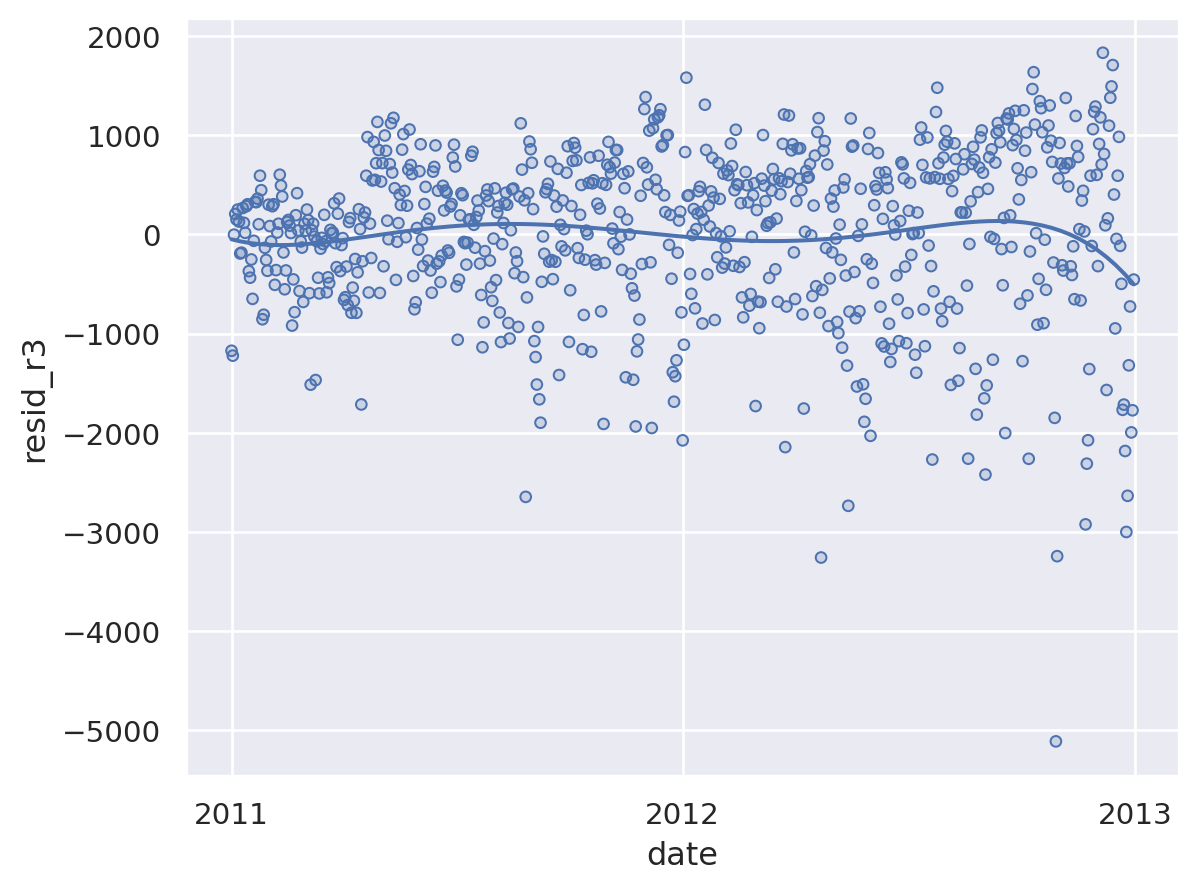

In [27]:
(
    so.Plot(bikes_daily_resid, x='date', y='resid_r3')
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(5))
)

## bikes_daily_resid.query('resid_r3 < -2000')["date"]를 보면, date들이 연말이나 추수감사절

In [28]:
bikes_daily_resid.query('resid_r3 < -2000')["date"]

238   2011-08-27
365   2012-01-01
448   2012-03-24
         ...    
723   2012-12-24
724   2012-12-25
725   2012-12-26
Name: date, Length: 19, dtype: datetime64[ns]

# 모델 비교
## casual을 log 변환시켜주면 분포가 훨씬 더 나이스해졌다.

In [29]:
mod_r_year = smf.ols("registered ~ year", data=bikes_daily).fit()
mod_r_temp = smf.ols("registered ~ year + temp + I(temp**2)", data=bikes_daily).fit()
mod_r_month = smf.ols("registered ~ year + temp + I(temp**2) + month", data=bikes_daily).fit()
mod_r_wday = smf.ols("registered ~ year + temp + I(temp**2) + month + wday", data=bikes_daily).fit()
print(
    f" year: {mod_r_year.rsquared:.3f}\n",
    f"year + temperature: {mod_r_temp.rsquared:.3f}\n",
    f"year + temperature + months: {mod_r_month.rsquared:.3f}\n",
    f"year + temperature + months + days of the week: {mod_r_wday.rsquared:.3f}",
)

 year: 0.353
 year + temperature: 0.653
 year + temperature + months: 0.686
 year + temperature + months + days of the week: 0.757


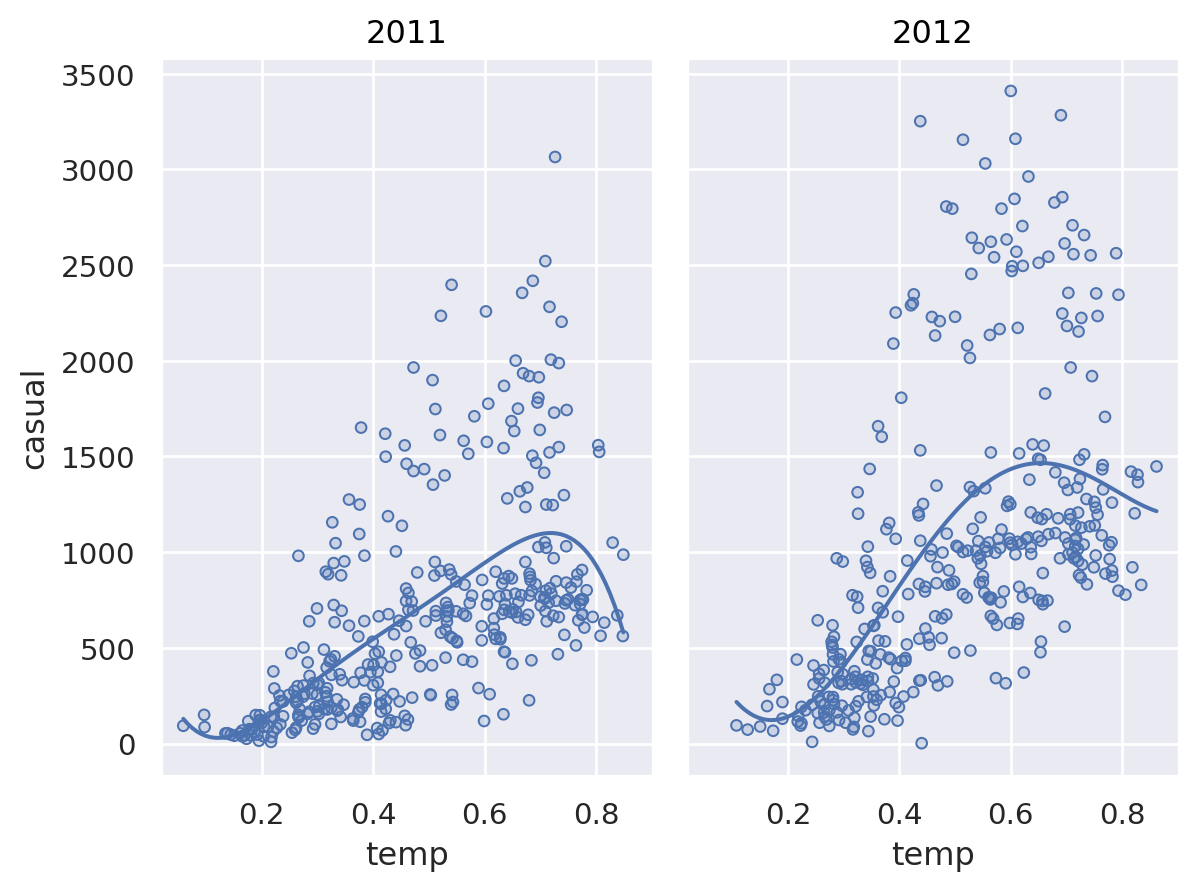

In [30]:
(
    so.Plot(bikes_daily, x='temp', y='casual')
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(5))
    .facet("year")
)

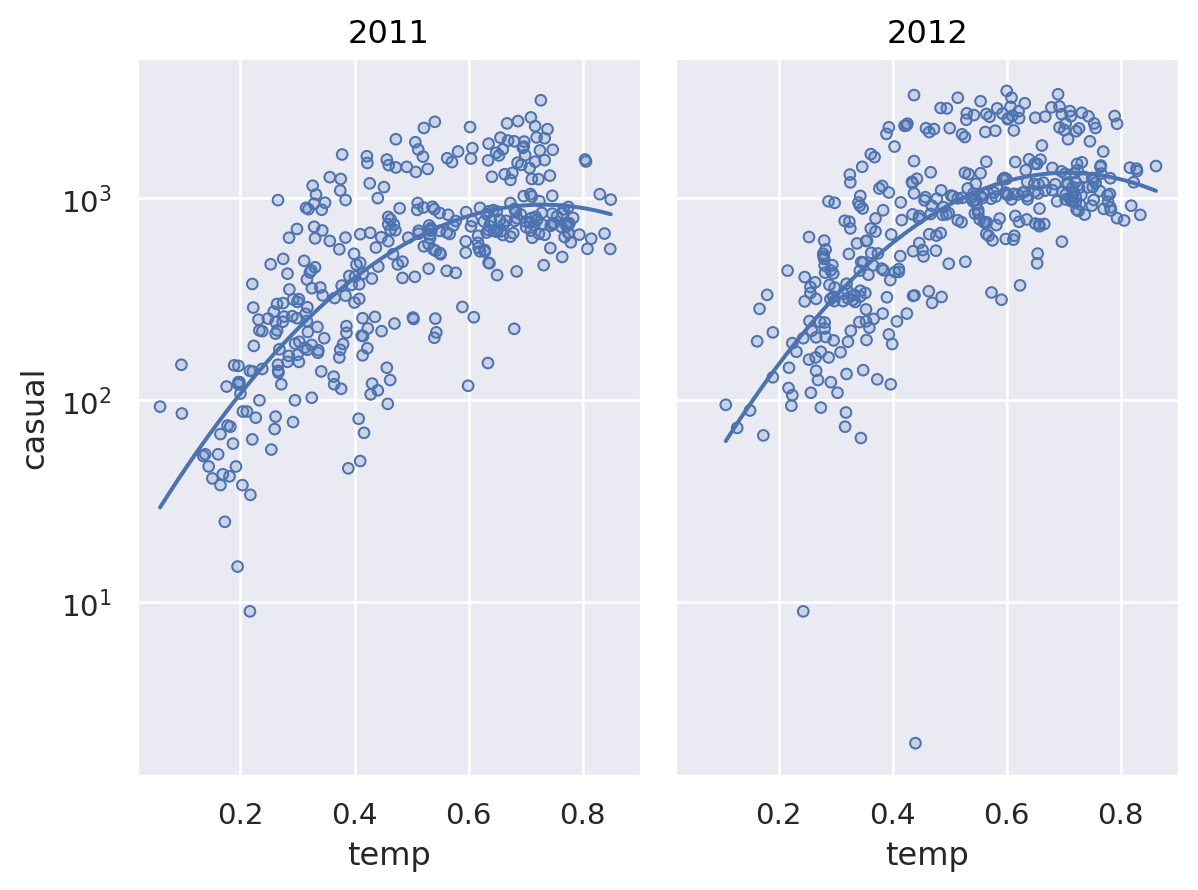

In [31]:
# log scale for y
(
    so.Plot(bikes_daily, x='temp', y='casual')
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(2))
    .facet("year")
    .scale(y="log")  # log scale
)

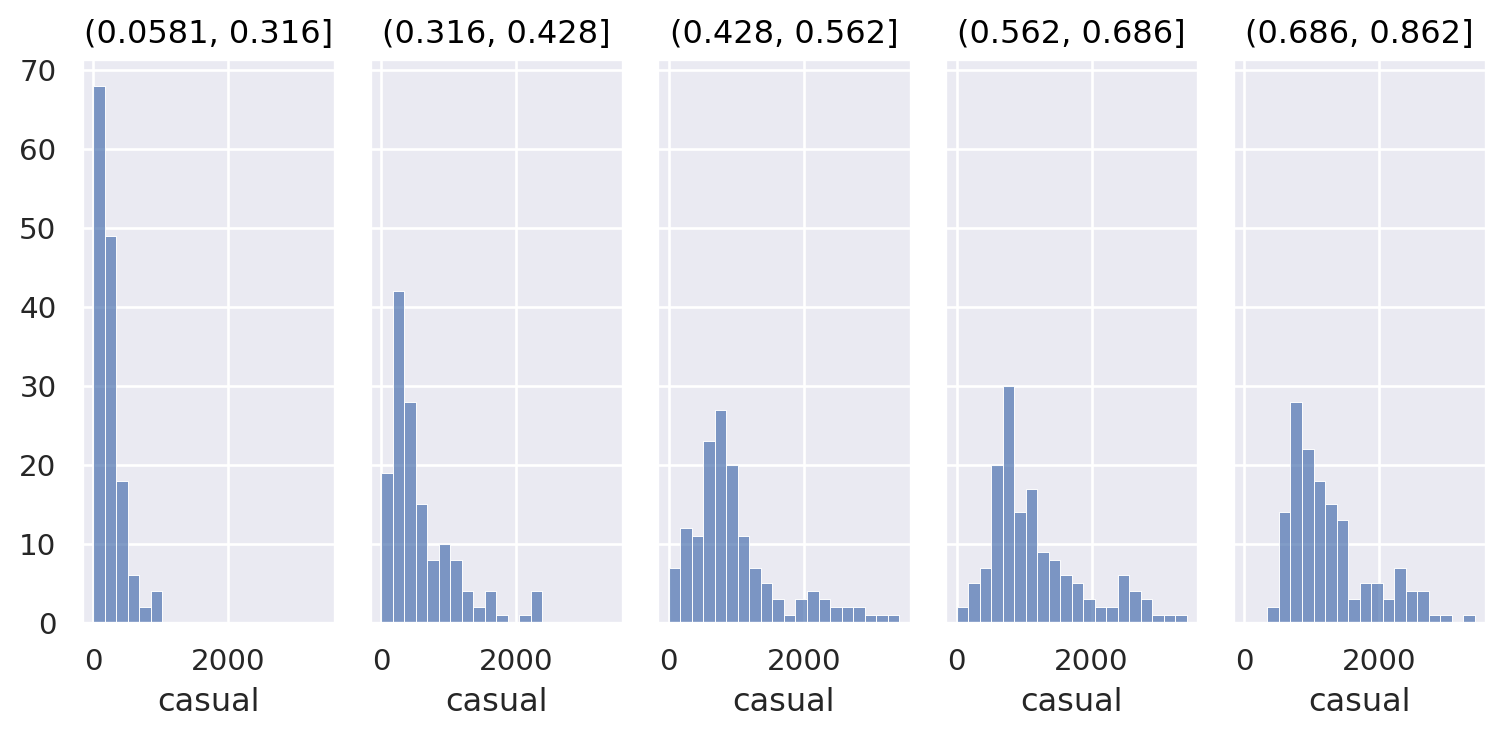

In [32]:
# 온도를 5개 구간으로 나누어 각 온도구간에서의 분포를 살펴봄
bikes_daily["temp_cat"] = pd.qcut(bikes_daily["temp"], 5)

(
    so.Plot(bikes_daily, x='casual')
    .add(so.Bars(), so.Hist())
    .facet("temp_cat")
    .layout(size=(8, 4))
)

In [33]:
bikes_daily["lcasual"] = np.log2(bikes_daily["casual"])

In [34]:
mod_c = smf.ols("lcasual ~ (temp + I(temp**2)) + year", data=bikes_daily).fit()

In [35]:
bikes_daily_resid["resid_c"] = mod_c.resid
bikes_daily_resid["lcasual"] = np.log(bikes_daily_resid["casual"])

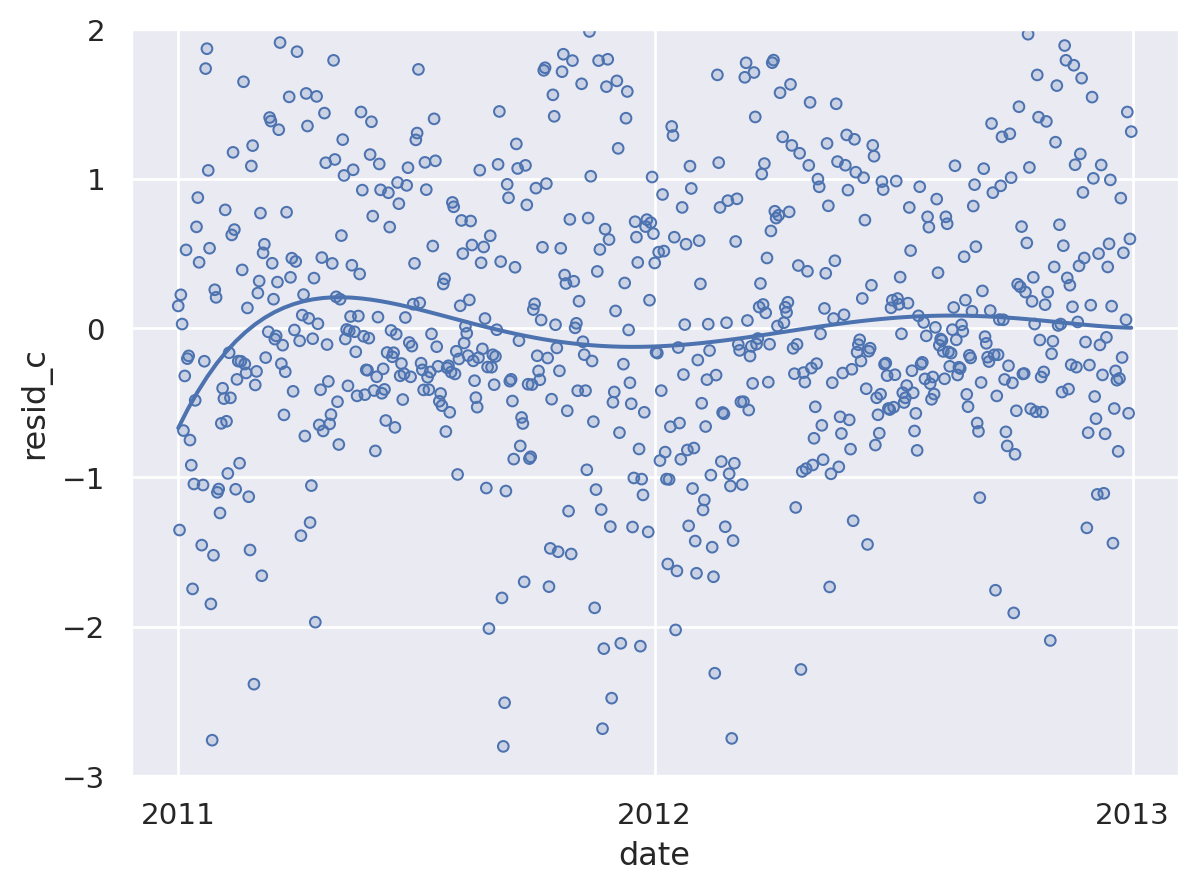

In [36]:
(
    so.Plot(bikes_daily_resid, x='date', y='resid_c')
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(5))
    .limit(y=(-3, 2))
)

In [37]:
mod_c2 = smf.ols("lcasual ~ (temp + I(temp**2)) + year + wday", data=bikes_daily).fit()
display(mod_c.rsquared, mod_c2.rsquared)

0.5504710020921331

0.723390139238294

In [38]:
mod_c_year = smf.ols("lcasual ~ year", data=bikes_daily).fit()
mod_c_temp = smf.ols("lcasual ~ year + temp + I(temp**2)", data=bikes_daily).fit()
mod_c_month = smf.ols(
    "lcasual ~ year + temp + I(temp**2) + month", data=bikes_daily
).fit()
mod_c_wday = smf.ols(
    "lcasual ~ year + temp + I(temp**2) + month + wday", data=bikes_daily
).fit()
print(
    f" year: {mod_c_year.rsquared:.3f}\n",
    f"year + temperature: {mod_c_temp.rsquared:.3f}\n",
    f"year + temperature + months: {mod_c_month.rsquared:.3f}\n",
    f"year + temperature + months + days of the week: {mod_c_wday.rsquared:.3f}",
)

 year: 0.056
 year + temperature: 0.550
 year + temperature + months: 0.584
 year + temperature + months + days of the week: 0.750


In [40]:
bikes_daily_resid2 = bikes_daily.assign(
    pred_c_year = lambda x: 2**mod_c_year.fittedvalues,
    pred_c_temp = lambda x: 2**mod_c_temp.fittedvalues,
    pred_c_month = lambda x: 2**mod_c_month.fittedvalues,
    pred_c_wday = lambda x: 2**mod_c_wday.fittedvalues,
)
bikes_daily_resid2.iloc[:, -4:]

pred_c_year  pred_c_temp  pred_c_month  pred_c_wday
0         448.98       298.94        179.48       362.04
1         448.98       334.83        193.21       376.74
2         448.98       102.90         88.24        71.99
..           ...          ...           ...          ...
728       726.30       236.35        258.64       461.10
729       726.30       240.80        261.89       446.74
730       726.30       176.47        212.62       163.98

[731 rows x 4 columns]

## original R_squared를 보면 차이가 있는데, 이건 y 값을 log 변환해주었기 때문에 y의 변량을 사용하는 r_Squared의 값이 달라진다.

In [41]:
from sklearn.metrics import r2_score

for col in ["pred_c_year", "pred_c_temp", "pred_c_month", "pred_c_wday"]:
    r2 = r2_score(bikes_daily_resid2["casual"], bikes_daily_resid2[col])
    print(f"{col}: {r2:.2f}")

pred_c_year: -0.08
pred_c_temp: 0.34
pred_c_month: 0.37
pred_c_wday: 0.75
